# Proof of concept: Training a structured, recurrent, delayed, long-term plastic SNN

Too many adjectives? Here's what I mean:
- **Structured, recurrent:** This network's connectivity matrix has constraints that mould the topology in specific, physiologically plausible ways. In particular, since backprop through between-layer recurrent connections is inadvisably complicated, we will implement arbitrarily complex cortical architecture within a single recurrent layer. In addition, neurons follow Dale's law, which means that their output weights are either all positive or all negative.
- **Delayed:** The recurrency has a temporal depth to emulate axonal delays.
- **Long-term plastic:** (some) synapses implement an activity-dependent long-term plasticity rule.
- **SNN:** Neurons are LIF in the forward pass, and we will use surrogate gradients for backpropagation.

We'll build this thing very slowly to allow the author, who has never used machine learning frameworks before, time to learn and digest along the way. The reference, heavily leaned upon for the basics, is fzenke's spytorch tutorial.

## Part 3: Time-varying input
We'll split the hidden layer into two subpopulations of a given type (exc/inh) that connect recurrently:

In [1]:
n_inputs  = 100
n_sub = [16, 16]
sub_sign = [1, -1]
n_hidden = sum(n_sub)
n_outputs = 2

Then, parameters for the simulation:

In [2]:
time_step = 1e-3
n_steps  = 500

And for training - having a GPU is fun!

In [3]:
batch_size = 256

In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

In [5]:
dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") 

### Input
Let's make the problem a little more interesting than the random input we used before. How about we supply combined oscillators and let the network do source separation?

In [6]:
max_freq = 40 # Hz, oscillator frequency
max_rate = 100 # Hz, firing frequency

In [7]:
freqs = torch.abs(torch.randn((1,1,n_outputs,1))).expand(batch_size,n_steps,-1,n_inputs) * max_freq

phases = torch.rand((1,1,n_outputs,1))

samplings = torch.rand((batch_size,1,n_outputs,n_inputs))

times = torch.arange(0,n_steps).reshape(1,-1,1,1) * time_step

raw_rates = torch.sin(2*np.pi*(freqs * times + phases)) * .5 + .5

rates = torch.sum(raw_rates * samplings, 2)/n_outputs

# Target with added baseline to avoid the zero-weights trap
y_data = torch.as_tensor(raw_rates[:,:,:,0], device=device, dtype=dtype) #+ 2

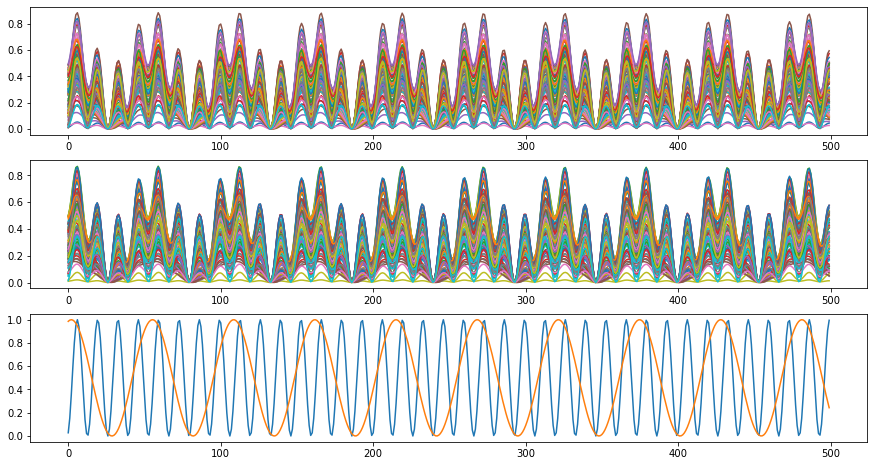

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(311)
plt.plot(rates[0].numpy())
plt.subplot(312)
plt.plot(rates[1].numpy())

plt.subplot(313)
plt.plot(y_data[0].cpu().numpy());

In [9]:
prob = rates.to(device)*time_step*max_rate
mask = torch.rand((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data[mask<prob] = 1.0

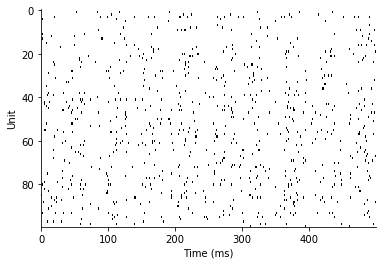

In [10]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

### SNN
The first point to tackle is how to simulate a spiking network on torch. fzenke has that bit figured out, defining membrane and synaptic time constants (and converting them to decay factors right away):

In [11]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Next, fzenke defines the weight matrices connecting input to hidden (`w1`) and hidden to output (`w2`). The weights are initialised randomly with a dispersal related to layer size and synaptic time constant.

In [12]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

def init_weights():
    w1 = torch.empty((n_inputs, n_hidden),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(n_inputs))

    w2 = torch.empty((n_hidden, n_outputs), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(n_hidden))
init_weights()

We'll skip the naive version without surrogate gradients, and dive right into the real thing with different forward and backward functions:

In [13]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient
#     scale = 10.0

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
#         grad = grad_input * torch.max(SurrGradSpike.scale*input + 1.0, torch.zeros_like(input))
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
spike_fn  = SurrGradSpike.apply

### Structure
To support Dale's law in this network, we'll have to explicitly enforce it at every step, otherwise the optimiser might try to mess with the weight signs. This means we need a readily enforceable template:

In [14]:
nested_signs = [[sign] * num for num,sign in zip(n_sub, sub_sign)]
flat_signs = [i for part in nested_signs for i in part]
w_signs = torch.tensor(flat_signs, device=device, dtype=dtype).diag()

# Normalise weights with:
# weights = torch.einsum('ab,bc->ac', w_signs, torch.abs(weights))

In addition, we'll need not only input weights, but also recurrent weights:

In [15]:
def init_weights():
    with torch.no_grad():
        w1 = torch.empty((n_inputs, n_hidden),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(n_inputs))

        w2 = torch.empty((n_hidden, n_outputs), device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(n_hidden))

        wr = torch.empty((n_hidden, n_hidden), device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(wr, mean=0.0, std=weight_scale/np.sqrt(n_hidden))
    return w1, w2, wr
w1, w2, wr = init_weights()

Putting it all together:

In [16]:
def run_snn(inputs):
    
    # Compute the input currents, which are effectively the input weight matrix `w1`
    # masked by the input spikes `x_data`:
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    
    # Zero-initialise state variables
    syn = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    out = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    
    # Add Dale's Law signs to recurrent weights
    # Not to readouts though, that makes training unstable!
    rec_weights = torch.matmul(w_signs, torch.abs(wr))

    # Lists to collect states
    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(n_steps):
        rec_syn = torch.einsum("ab,bc->ac", out, rec_weights)
        
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        rst[mthr > 0] = 1.0

        new_syn = alpha*syn +h1[:,t] +rec_syn
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,n_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,n_outputs), device=device, dtype=dtype)
    out_rec = []
    for t in range(n_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [17]:
out_rec,other_recs = run_snn(x_data)

Define a helper function to visualise activity:

In [18]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

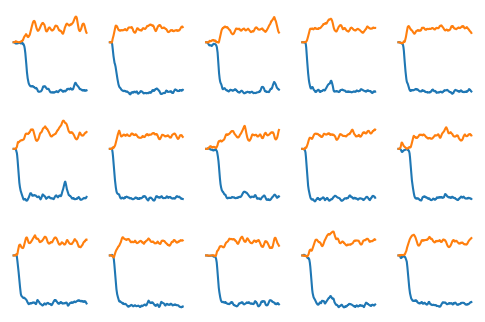

In [19]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

There's no such thing as accuracy any more, but we can look at the loss:

In [20]:
loss_fn = torch.nn.MSELoss()
print("Mean squared error: %.3f" % loss_fn(out_rec, y_data))

Mean squared error: 1895.590


I have no idea whether this will train! Let's try.

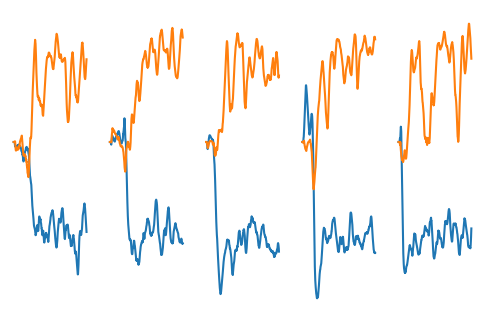

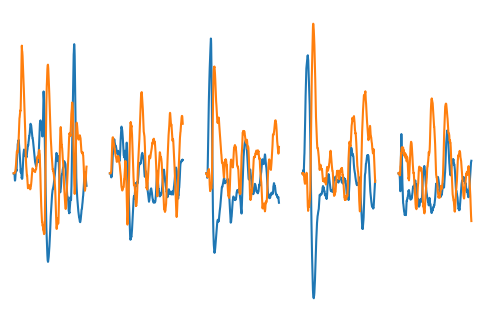

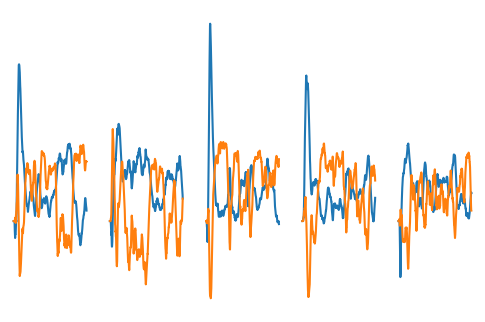

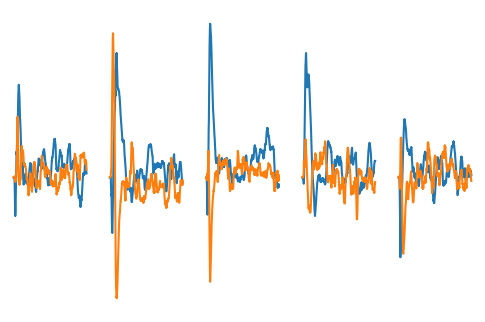

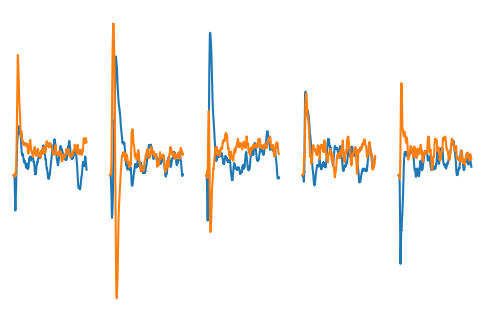

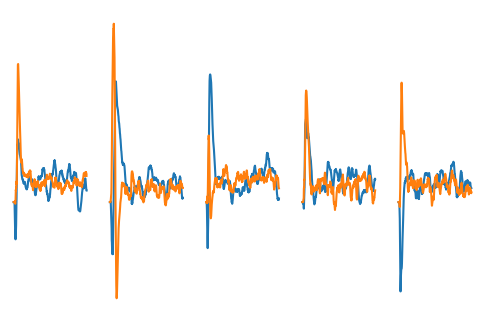

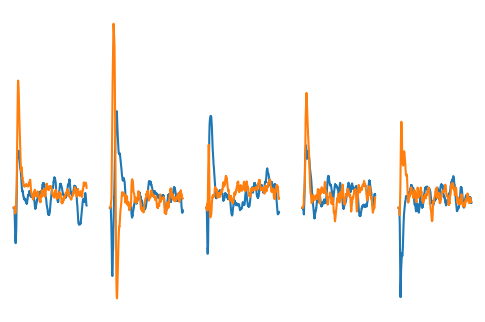

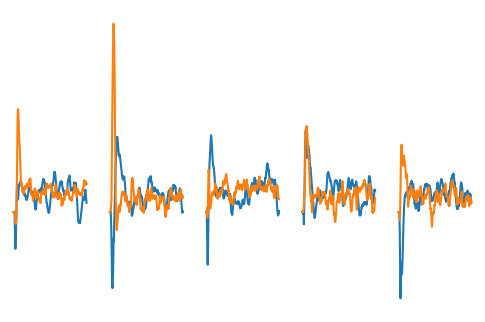

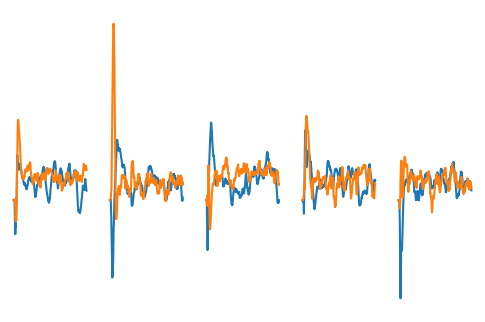

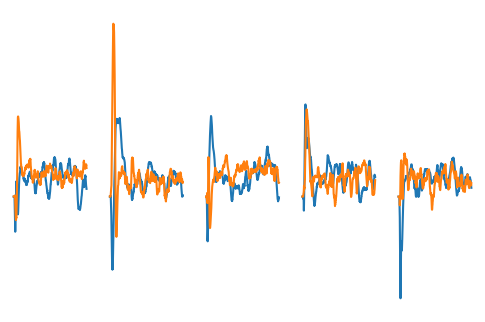

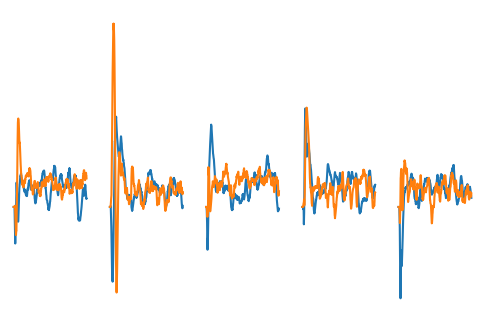

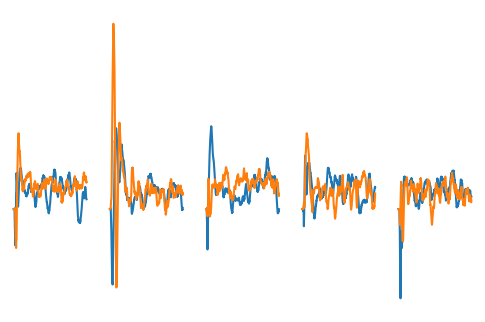

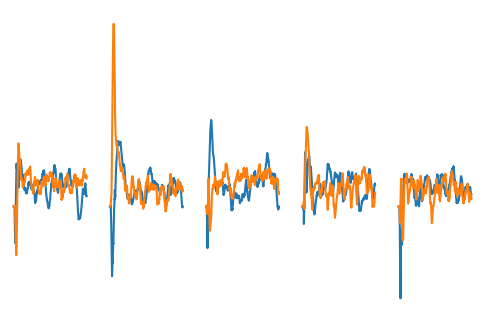

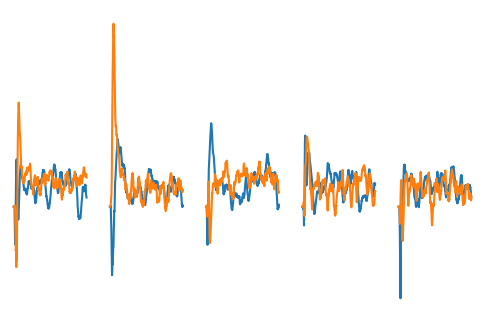

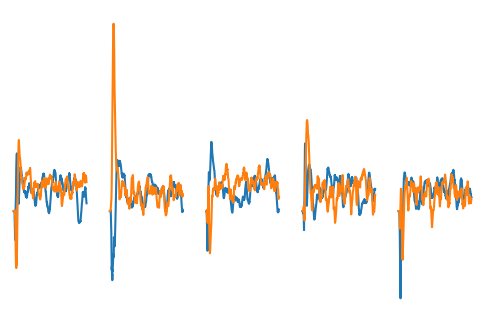

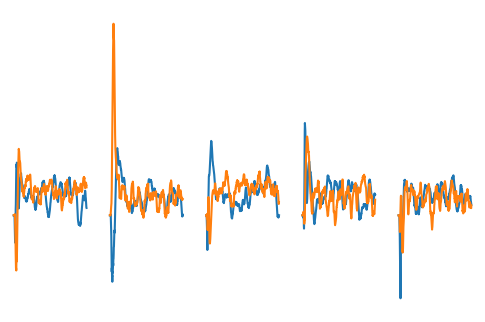

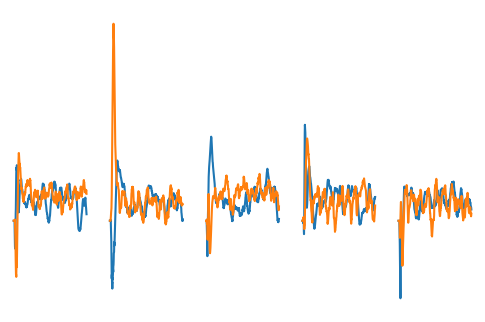

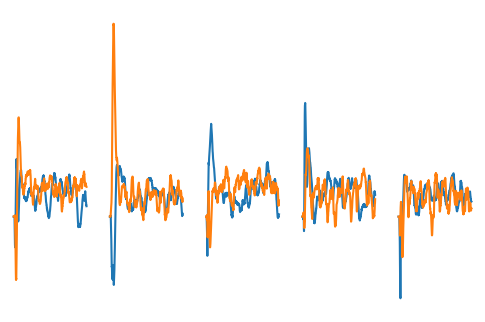

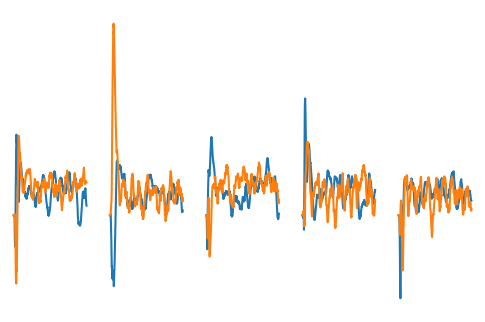

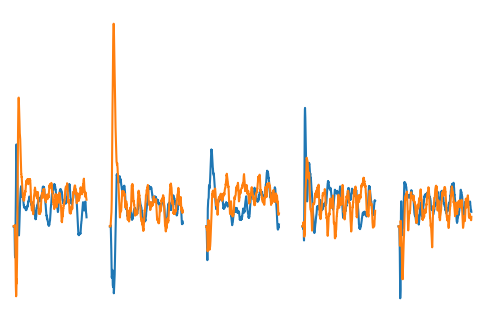

In [21]:
w1,w2,wr = init_weights()

params = [w1,w2,wr] # The parameters we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

# The optimization loop
loss_hist = []
for e in range(200):
    # run the network and get output
    output,_ = run_snn(x_data) 
    
    # compute the loss
    loss_val = loss_fn(output, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    # store loss value
    loss_hist.append(loss_val.item())
    
    if e%10 == 0:
        fig=plt.figure(dpi=100)
        plot_voltage_traces(output,dim=(1,5))

0.3034268021583557


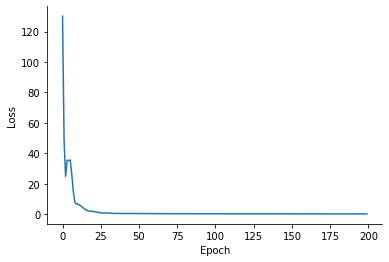

In [22]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()
print(loss_hist[-1])

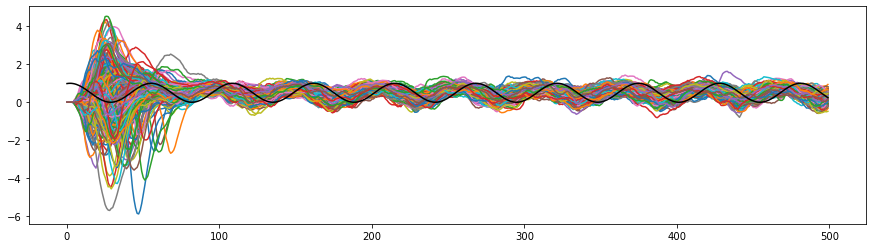

In [29]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,1].detach().cpu().numpy().T);
plt.plot(y_data[0,:,1].cpu().numpy(), color='black')

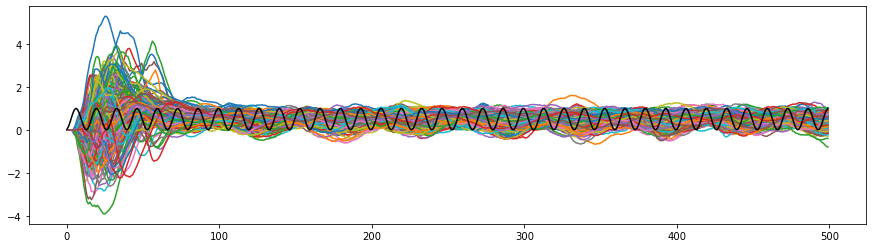

In [30]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,0].detach().cpu().numpy().T);
plt.plot(y_data[0,:,0].cpu().numpy(), color='black')

Well, this is a surprisingly difficult problem. I'm guessing a deeper structure might help, and then of course time scale adaptation, too.